## Survival Analysis: time varying survival regression

Materials:
- Time varying survival regression [Link](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html)
- TA Review on Accelerated Failure Time Models [Link](https://www.ripublication.com/ijss17/ijssv12n2_15.pdf)
- The Cox Proportional Hazards Model [Link](https://bookdown.org/sestelo/sa_financial/cox.html)
- On Ranking in Survival Analysis: Bounds on the Concordance Index [Link](https://proceedings.neurips.cc/paper/2007/file/33e8075e9970de0cfea955afd4644bb2-Paper.pdf)

### Cox's time-varying proportional hazard model: <br/>
$ h(t|x(t) = h_0(t) \ exp([x(t)- \bar{x}]' \ \beta) $

**Dataset creation for time-varying regression** <br/>
lifelines requires that the dataset be in what is called the long format. This looks like one row per state change, including an ID, the left (exclusive) time point, and right (inclusive) time point.

In [42]:
import pandas as pd
from lifelines.utils import to_long_format

In [43]:
# data from relational database with durations and event flags
base_df = pd.DataFrame([
  {'id': 1, 'duration': 10, 'event': True, 'var1': 0.1},
  {'id': 2, 'duration': 12, 'event': True, 'var1': 0.5}
])


In [44]:
base_df

,id,duration,event,var1
0,1,10,True,0.1
1,2,12,True,0.5


In [45]:
base_df = to_long_format(base_df, duration_col="duration")

In [46]:
base_df

,id,event,var1,start,stop
0,1,True,0.1,0,10
1,2,True,0.5,0,12


In [47]:
from lifelines.utils import add_covariate_to_timeline

In [48]:
# secondary dataset that references future measurements - variables that change over time
# time - duration from the entry point
cv = pd.DataFrame([
  {'id': 1, 'time': 0, 'var2': 1.4},
  {'id': 1, 'time': 4, 'var2': 1.2},
  {'id': 1, 'time': 8, 'var2': 1.5},
  {'id': 2, 'time': 0, 'var2': 1.6},

])

In [49]:
cv

,id,time,var2
0,1,0,1.4
1,1,4,1.2
2,1,8,1.5
3,2,0,1.6


In [52]:
# use `add_covariate_to_timeline` to fold the covariate dataset into original dataset
df = add_covariate_to_timeline(base_df, cv, 
                               duration_col="time", 
                               id_col="id", 
                               event_col="event").columns()

In [54]:
cols = ['id','start','stop','var1','var2','event']

In [56]:
df[cols]

,id,start,stop,var1,var2,event
0,1,0,4.0,0.1,1.4,False
1,1,4,8.0,0.1,1.2,False
2,1,8,10.0,0.1,1.5,True
3,2,0,12.0,0.5,1.6,True


In [ ]:
# we can add multiple covariates with pipe:

# df = base_df.pipe(add_covariate_to_timeline, cv1, duration_col="time", id_col="id", event_col="event")\
#             .pipe(add_covariate_to_timeline, cv2, duration_col="time", id_col="id", event_col="event")\
#             .pipe(add_covariate_to_timeline, cv3, duration_col="time", id_col="id", event_col="event")

In [58]:
# secondary dataset - event-based with values in the matrix denote times since the subject's birth

event_df = pd.DataFrame([
    {'id': 1, 'E1': 1.0},
    {'id': 2, 'E1': None},
    {'id': 3, 'E1': 3.0},
])
event_df

,id,E1
0,1,1.0
1,2,NaN
2,3,3.0


In [ ]:
# cannot add to baseline df, but can convert and add with `covariates_from_event_matrix`

In [59]:
from lifelines.utils import covariates_from_event_matrix

In [60]:
cv = covariates_from_event_matrix(event_df, id_col="id")

In [61]:
cv

,id,duration,E1
0,1,1.0,1
1,2,inf,1
2,3,3.0,1


In [63]:
base_df = add_covariate_to_timeline(base_df, cv, duration_col="duration", id_col="id", event_col="event")


In [64]:
base_df

,start,E1,var1,stop,id,event
0,0.0,NaN,0.1,1.0,1,False
1,1.0,1.0,0.1,10.0,1,True
2,0.0,NaN,0.5,12.0,2,True


**DFitting time-varying model** <br/>
Fitting the Cox model to the data involves an iterative gradient descent. lifelines takes extra effort to help with convergence, so please be attentive to any warnings that appear.

In [65]:
from lifelines import CoxTimeVaryingFitter

In [69]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(df, id_col="id", event_col="event", start_col="start", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 0.66626, step_size = 0.95000, ll = -0.69315, newton_decrement = 0.36538, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.12988, step_size = 0.95000, ll = -0.31149, newton_decrement = 0.01022, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01422, step_size = 0.95000, ll = -0.30098, newton_decrement = 0.00011, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00084, step_size = 1.00000, ll = -0.30087, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -0.30087, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.


/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column var1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'var1'].var())
>>> print(df.loc[~events, 'var1'].var())

A very low variance means that the column var1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxTimeVaryingFitter: fitted with 4 periods, 2 subjects, 2 events>

/Users/antonermak/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxTimeVaryingFitter: fitted with 4 periods, 2 subjects, 2 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 2
 number of periods = 4
  number of events = 2
partial log-likelihood = -0.30
  time fit was run = 2022-09-07 08:29:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
var1       -3.89       0.02       5.35           -14.38             6.60                 0.00               733.78
var2       -1.33       0.26       9.04           -19.05            16.38                 0.00             1.31e+07

            cmp to     z    p   -log2(p)
covariate                               
var1          0.00 -0.73 0.47       1.10
var2          0.00 -0.15 0.88       0.18
---
Partial AIC = 4.60
log-likelihood ratio test = 0.78 on 2 df
-log2(p) of ll-ratio test = 0.57

<AxesSubplot:xlabel='log(HR) (95% CI)'>

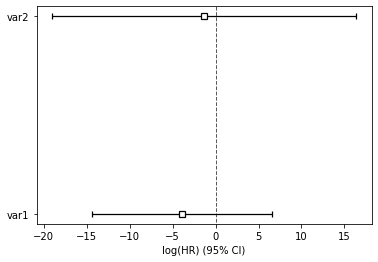

In [70]:
ctv.print_summary()
ctv.plot()